# 个人睡眠分析报告

## Step 0 明确目的

** 背景 **

一直在关注数据分析相关的内容，很希望自己能做一份数据分析报告，通过这种方式完整地体验一下数据分析的流程，也能对这段时间的学习成果进行检验。而作为第一份比较完整的分析报告自然要选择一个自己最熟悉、感兴趣的领域，同时又有足够的数据和切入点，于是选择尝试做个人健康数据的相关分析。

** 分析目的 **

通过对个人睡眠数据的相关分析，用可视化的方式使自己对最近一段时间的睡眠状况有更直观的了解，同时根据历史数据指导自己在未来一段时间，如何更合理的睡眠以达到更高的睡眠质量。另外，对于一些情况下的特殊数据，鉴于其数据量很小，不列入分析的范围之内。

## Step 1 数据获取

** 数据来源 **

报告中的数据均来自Sleep Cycle，它是一款优秀的睡眠时间与质量监测的App，可以记录每晚的入睡时间、起床时间、睡眠质量以及睡眠质量等数据。在利用pandas分析之前，先利用Excel对App导出数据做了简单的数据清洗，并保存为名为“sleepdata”的CSV文件。

** 读入数据 **

In [548]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib as plt
from datetime import datetime
from dateutil.parser import parse

In [549]:
df = pd.read_csv("sleepdata.csv")

#### 检视数据源

In [550]:
df.head()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps
0,2016-01-22,00:58:40,2016-01-22,07:28:55,76%,6:30,108.0
1,2016-01-23,00:58:09,2016-01-23,07:30:18,75%,6:32,95.0
2,2016-01-24,01:25:00,2016-01-24,07:30:41,73%,6:05,370.0
3,2016-01-25,01:28:17,2016-01-25,07:32:07,55%,6:03,0.0
4,2016-01-27,01:14:10,2016-01-27,08:10:41,78%,6:56,1110.0


In [551]:
df.tail()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps
226,2016-12-16,02:15:49,2016-12-16,08:58:40,64%,6:42,7307.0
227,2016-12-17,01:12:41,2016-12-17,08:05:34,77%,6:52,8812.0
228,2016-12-18,03:00:00,2016-12-18,10:18:10,78%,7:18,3239.0
229,2016-12-20,01:19:04,2016-12-20,08:18:05,82%,6:59,4855.0
230,2016-12-21,00:28:43,2016-12-21,07:26:09,70%,6:57,6029.0


数据源从2016/1/22-2016/12/21共有231条数据，从左到右的栏依次为睡眠记录开始日期、开始时间、结束日期、结束时间、睡眠质量、床上时间和当天步数

In [552]:
df.dtypes

start_date      object
start_time      object
end_date        object
end_time        object
quality         object
time_in_bed     object
steps          float64
dtype: object

导入的数据中前六列数据都是字符串类型，只有最后一列为float

In [553]:
df.isnull().sum()

start_date     0
start_time     0
end_date       0
end_time       0
quality        0
time_in_bed    0
steps          1
dtype: int64

数据中只有steps一列中存在NULL值

## Step2 数据清洗

### 转换数据类型

#### 转换日期的数据类型 

start_date和end_date的日期数据是str数据类型，为便于进一步时间序列分析，需要将str类型的数据转换成datetime类型的数据

In [554]:
df['start_date'] = df['start_date'].str.replace("/", '-')
df['end_date'] = df['end_date'].str.replace("/", '-')

In [555]:
df['start_date'] = [datetime.strptime(x, '%Y-%m-%d') for x in df['start_date']]
df['end_date'] = [datetime.strptime(x, '%Y-%m-%d') for x in df['end_date']]

In [556]:
type(df['start_date'][1])

pandas.tslib.Timestamp

转换数据类型后，日期的数据类型由str变成了Timestamp

#### quality数据转换类型

将睡眠数据的%去掉，有str类型转换成int类型的数据

In [557]:
df['quality'] = df['quality'].str.replace('%', '')
df['quality'] = df['quality'].str.replace(';', '')

Q: 为什么是str.replace() ?

In [558]:
# df['quality'].str.extract('(\d\d)%') 利用正则表达式

In [559]:
#df['quality'].astype(int) # 为何没有转换成int类型数据？ 产生新的Series而不在原数据上修改

In [560]:
df['quality'] = df['quality'].astype(int)

#### 转换time_in_bed数据格式

原始的睡眠数据中睡眠时长的数据是以str类型的数据表示，需要将分钟转化成小时以转化成float类型的数据

首先，以数据中的':'作为分割符合将数据拆分成hours和minutes

In [561]:
time_bed = pd.DataFrame((x.split(':') for x in df['time_in_bed']), columns=['hours','minutes'])
time_bed.head()

,hours,minutes
0,6,30
1,6,32
2,6,05
3,6,03
4,6,56


In [562]:
df['time_in_bed_minute'] = time_bed['minutes']
df['time_in_bed_hour'] = time_bed['hours']

In [563]:
df.tail()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps,time_in_bed_minute,time_in_bed_hour
226,2016-12-16,02:15:49,2016-12-16,08:58:40,64,6:42,7307.0,42,6
227,2016-12-17,01:12:41,2016-12-17,08:05:34,77,6:52,8812.0,52,6
228,2016-12-18,03:00:00,2016-12-18,10:18:10,78,7:18,3239.0,18,7
229,2016-12-20,01:19:04,2016-12-20,08:18:05,82,6:59,4855.0,59,6
230,2016-12-21,00:28:43,2016-12-21,07:26:09,70,6:57,6029.0,57,6


将hours和minutes转换成int类型数据

In [564]:
df['time_in_bed_minute'] = df['time_in_bed_minute'].str.replace(';', '')

Q: 为什么会报错？

In [565]:
for i in df['time_in_bed_hour'].index:
    if df['time_in_bed_hour'][i] == '':
        df['time_in_bed_hour'][i] = '0' 

/Users/saxon/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [566]:
df['time_in_bed_minute'] = df['time_in_bed_minute'].astype(int)
df['time_in_bed_hour'] = df['time_in_bed_hour'].astype(int)

合并数据，得到float类型的time_in_bed数据，即睡眠时长

In [567]:
df['time_in_bed_minute'] = df['time_in_bed_minute']/60

In [569]:
df['bed_time'] = df['time_in_bed_minute'] + df['time_in_bed_hour']

删除用于数据清洗时辅助的两列数据

In [571]:
df = df.drop('time_in_bed_minute', axis=1)
df = df.drop('time_in_bed_hour', axis=1)

In [613]:
df.dtypes

start_date        datetime64[ns]
start_time                object
end_date          datetime64[ns]
end_time                  object
quality                    int64
time_in_bed               object
steps                    float64
bed_time                 float64
start_num_time           float64
dtype: object

#### 转换start_time数据类型

将入睡时间转换成float类型的数据

In [573]:
start_time = pd.DataFrame((x.split(':') for x in df['start_time']), columns=['start_hours','start_minutes','start_seconds'])
start_time.head()

,start_hours,start_minutes,start_seconds
0,00,58,40
1,00,58,09
2,01,25,00
3,01,28,17
4,01,14,10


In [574]:
df['start_minute'] = start_time['start_minutes']
df['start_hour'] = start_time['start_hours']
df['start_second'] = start_time['start_seconds']

In [575]:
df['start_minute'] = df['start_minute'].astype(int)
df['start_hour'] = df['start_hour'].astype(int)
df['start_second'] = df['start_second'].astype(int)

合并数据为start_num_time

In [576]:
df['start_minute'] = df['start_minute']/60

In [577]:
df['start_num_time'] = df['start_hour'] + df['start_minute']

删除转换过程中辅助的数据列

In [578]:
df = df.drop('start_hour', axis=1)
df = df.drop('start_minute', axis=1)
df = df.drop('start_second', axis=1)

In [579]:
df.head()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps,bed_time,start_num_time
0,2016-01-22,00:58:40,2016-01-22,07:28:55,76,6:30,108.0,6.500000,0.966667
1,2016-01-23,00:58:09,2016-01-23,07:30:18,75,6:32,95.0,6.533333,0.966667
2,2016-01-24,01:25:00,2016-01-24,07:30:41,73,6:05,370.0,6.083333,1.416667
3,2016-01-25,01:28:17,2016-01-25,07:32:07,55,6:03,0.0,6.050000,1.466667
4,2016-01-27,01:14:10,2016-01-27,08:10:41,78,6:56,1110.0,6.933333,1.233333


为了便于之后的进一步分析，将入睡时间在24点之前的数据统一减去24转换为负数

Q: 如何修改特定行的值？

In [580]:
# 方法一：会报warning，但结果正确
# right = df[df['start_num_time'] > 21]['start_num_time'] - 24
# for i in df[df['start_num_time'] > 21].index:
#     df['start_num_time'][i] = right[i]

In [581]:
# 方法二：用iloc
df.iloc[df[df['start_num_time'] > 21].index, -1] = df[df['start_num_time'] > 21]['start_num_time'] - 24

### 清除异常数据

转换完数据类型之后，需要进一步的数据清洗，即将数据中明显异常的数据清除

#### 删除quality异常数据

平时的睡眠记录中，经常有测试软件时的数据记录，并非真实的睡眠情况，因此将睡眠质量不大于10%的数据剔除

In [582]:
for i in range(df['quality'].shape[0]):
    if df['quality'][i] <= 10:
        df = df.drop(i)

In [583]:
df = df.reset_index(drop=True)

删除了异常数据之后需要将index重置，以免之后的数据整理工作出现错误

#### 删除start_num_time异常的数据

根据对自己睡眠状况的了解，入睡时间在早上6点之后晚上9点之前的数据属于极少见的特殊情况，根据分析目的我们需要分析的是常规情况下的整体数据规律，所以将其清楚

In [584]:
# df['start_num_time'].loc(7)

特殊情况下的入睡时间数据，共6项异常数据

In [585]:
for i in df['start_num_time']:
    if i < 21 and i >6:
        print(i)

7.0
15.8666666667
12.35
14.1666666667
14.3666666667
19.0


Q: 如何选取入睡时间为7的特定行数据 ？

In [586]:
# df[df['start_num_time'] == 7]['start_date']

In [587]:
for i in range(df['start_num_time'].shape[0]):
    if int(df['start_num_time'][i]) < 21 and int(df['start_num_time'][i]) > 6:
        df = df.drop(i)

In [588]:
df = df.reset_index(drop=True)

In [589]:
for i in df['start_num_time']:
    if i < 21 and i >6:
        print(i)

#### 删除bed_time异常数据

In [590]:
for i in range(df['bed_time'].shape[0]):
    if int(df['bed_time'][i]) < 3:
        df = df.drop(i)

In [591]:
df = df.reset_index(drop=True)

同理，将睡眠数据中，睡眠时间小于三小时的特殊记录删除

## Step 3 描述分析

描述分析是最基本的一种分析统计方法，分为两大部分：数据描述和指标统计。数据描述即用来对数据进行基本情况的刻画，包括数据总数、时间跨度等方面；指标统计则是用来分析实际情况的数据指标，可以粗略分为变化、分布、对比、预测四大类。

### 数据描述

经过数据清洗后的数据共有216条，时间跨度从2016年1月22日到2016年12月21日共334天，使用该App的频率约为0.65

平均的入睡时间是1:05，平均睡眠时长为6小时45分钟，平均睡眠质量为69.0%，修正后的每日平均步数为7950步

In [592]:
df.describe()

,quality,steps,bed_time,start_num_time
count,216.000000,216.000000,216.000000,216.000000
mean,68.958333,7840.259259,6.755170,1.096914
std,12.245668,4328.477827,0.771820,1.054496
min,27.000000,0.000000,3.283333,-2.900000
25%,61.000000,5347.750000,6.383333,0.466667
50%,70.000000,7387.000000,6.833333,1.083333
75%,77.000000,9296.750000,7.187500,1.600000
max,96.000000,25459.000000,8.900000,4.350000


In [620]:
step = []
for i in df['steps']:
    if i != 0:
        step.append(i)
np.mean(step)

7950.68544600939

In [593]:
df.head()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps,bed_time,start_num_time
0,2016-01-22,00:58:40,2016-01-22,07:28:55,76,6:30,108.0,6.500000,0.966667
1,2016-01-23,00:58:09,2016-01-23,07:30:18,75,6:32,95.0,6.533333,0.966667
2,2016-01-24,01:25:00,2016-01-24,07:30:41,73,6:05,370.0,6.083333,1.416667
3,2016-01-25,01:28:17,2016-01-25,07:32:07,55,6:03,0.0,6.050000,1.466667
4,2016-01-27,01:14:10,2016-01-27,08:10:41,78,6:56,1110.0,6.933333,1.233333


In [594]:
df.tail()

,start_date,start_time,end_date,end_time,quality,time_in_bed,steps,bed_time,start_num_time
211,2016-12-16,02:15:49,2016-12-16,08:58:40,64,6:42,7307.0,6.700000,2.250000
212,2016-12-17,01:12:41,2016-12-17,08:05:34,77,6:52,8812.0,6.866667,1.200000
213,2016-12-18,03:00:00,2016-12-18,10:18:10,78,7:18,3239.0,7.300000,3.000000
214,2016-12-20,01:19:04,2016-12-20,08:18:05,82,6:59,4855.0,6.983333,1.316667
215,2016-12-21,00:28:43,2016-12-21,07:26:09,70,6:57,6029.0,6.950000,0.466667


在所有的睡眠数据中，睡眠最早的时间是21:06，最晚的睡眠时间是4:20

In [595]:
def convert_time(x):
    h = int(x)
    m = (x-h) * 60
    if h >= 0:
        return str(h) + ":" + str(int(m))
    else:
        a = int(x+24)
        b = (24+x-a) * 60
        return str(a) + ":" + str(int(b))

In [596]:
convert_time(df['start_num_time'].min())

'21:6'

In [597]:
convert_time(df['start_num_time'].max())

'4:20'

### 数据可视化描述

#### 数据分布

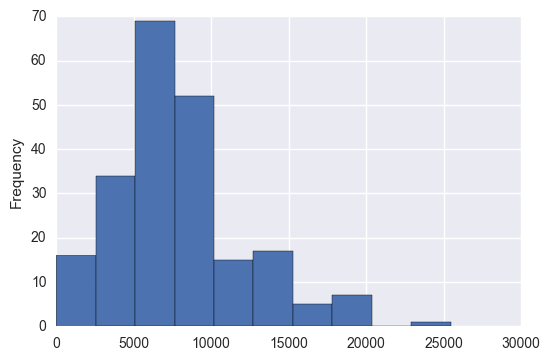

In [622]:
df['steps'].plot(kind='hist')

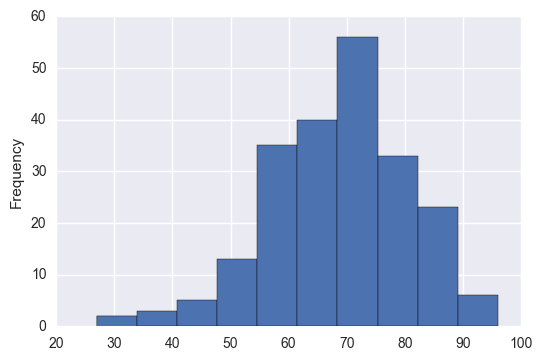

In [624]:
df['quality'].plot(kind='hist')

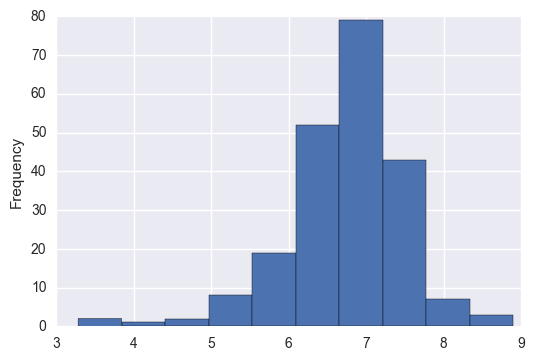

In [625]:
df['bed_time'].plot(kind='hist')

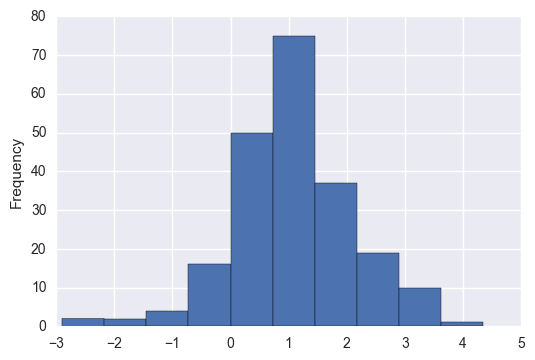

In [627]:
df['start_num_time'].plot(kind='hist')

#### 数据之间的联系

步数与睡眠质量数据之间的联系

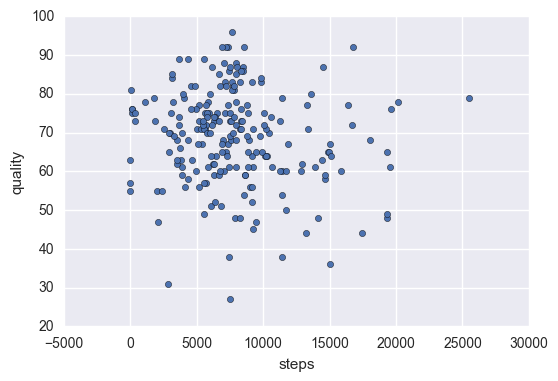

In [608]:
df.plot(kind="scatter", x="steps", y="quality")

睡眠时长与睡眠质量之间的联系

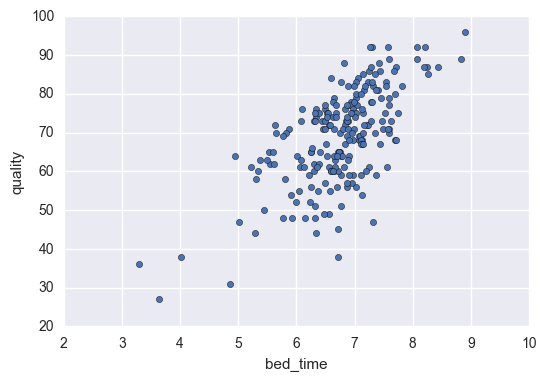

In [609]:
df.plot(kind="scatter", x="bed_time", y="quality")

步数和睡眠时长之间的联系

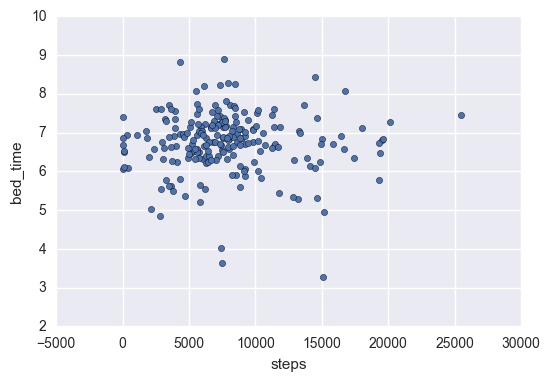

In [610]:
df.plot(kind="scatter", x="steps", y="bed_time")

入睡时间和睡眠质量之间的联系

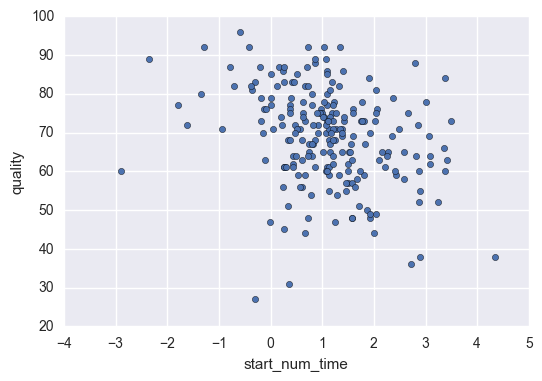

In [626]:
df.plot.scatter(x='start_num_time', y='quality')

## Step 4 分析与结论

### 决定睡眠质量的因素

我们可以合理地假设，睡眠质量与睡眠时长、入睡时间以及当天运动步数有较大的相关性，例如睡眠时长越长睡眠质量也相应越高。为了验证该假设，我们结合睡眠质量数据和其他相关数据进行绘图：

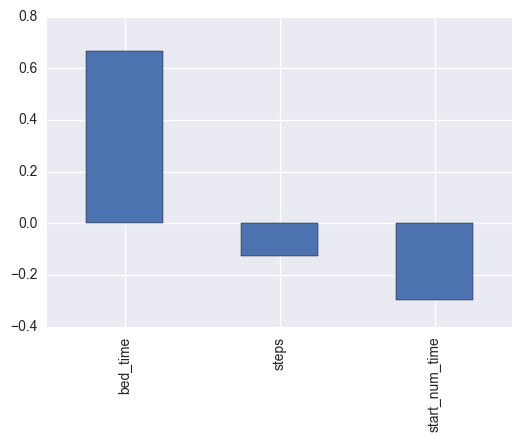

In [621]:
df.corr()['quality'][["bed_time", "steps", "start_num_time"]].plot.bar()

#### 睡眠时长

相关性最高的是睡眠时长，相关系数达到了0.67左右，其与睡眠质量呈强正相关性，但还需要做显著性差异检验，即t-test，来检验两组数据是否显著相关。

通过观察睡眠时长与睡眠质量数据的散点图发现，睡眠时长大于8小时的睡眠记录全部达到了83%以上的高睡眠质量，最高的睡眠质量的记录也是睡眠时长最长（约9小时），而睡眠时长在5小时以下的数据也普遍在40%以下的睡眠质量。可见睡眠时长对睡眠质量的影响很大，要想达到更好的睡眠效果，最好保持8-9小时的睡眠时间。

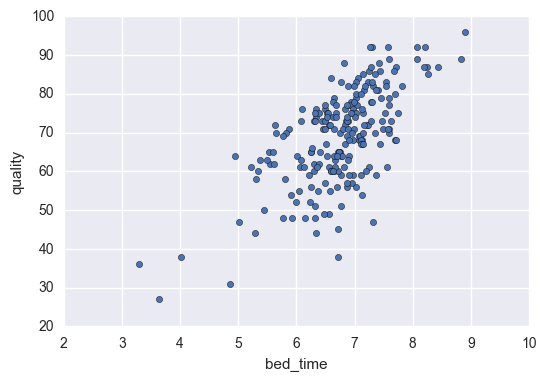

In [628]:
df.plot(kind="scatter", x="bed_time", y="quality")

但需要注意的是，睡眠质量的计算是由App内部计算得出，其权威性和准确度仍然存疑，可能其算法中睡眠时长也是重要的参数之一

#### 入睡时间

入睡时间与睡眠质量呈较强的负相关关系，相关系数接近-0.3，即入睡时间越晚当天的睡眠质量可能越差

通过观察三点图可以发现，虽然23:30之前的数据量较小，但除了一个特殊值外睡眠质量全部都保持在70%以上，最高的睡眠质量也是在十一点半之前入睡，而23:30之后的睡眠质量则方差较大，总体保持下行的趋势

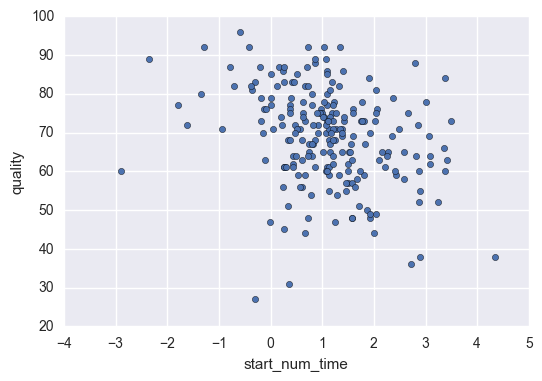

In [632]:
df.plot.scatter(x='start_num_time', y='quality')

二者出现负相关的原因，可能是宿舍舍友的起床时间比较早会发出噪音，以及白天的太阳光照射因素，这些都会影响晚睡晚起时的睡眠质量

一方面，可以发现在23:30之前睡觉可以基本保证70%较为稳定的较高睡眠质量；另一方面，偶尔晚睡也不必有太大的心理压力，因为即使三点左右入睡，依然有可能保持80-90%的睡眠质量

### 个人睡眠策略

1. 提高睡眠时间，最佳的睡眠时间是8-9小时，即使特殊情况最少也不要低于5小时的睡眠

2. 尽量早睡，最好保持在23:30之前入睡

3. 若不得不晚睡，也不用有太大心理压力，提早拉好窗帘并告知舍友不要打扰休息

### 注意事项

为了进一步提高该数据报告结论的合理性，还需要对一些因素进行进一步分析和验证：

1. 是否睡眠时长越长相应的睡眠质量也越高，以及最佳的睡眠时间是多少，缺少8小时以上更多的睡眠数据对这些问题进行进一步论证

2. 23:30之前入睡的睡眠记录较少，因此得出的结论可信度不太够，之后需要补充早睡的记录数据

3. 影响晚睡晚起时睡眠质量的因素只是根据个人经验的猜测，依然需要设置变量进行进一步验证，比如保证白天安静黑暗的环境进行睡眠数据的记录和对比分析

# 操作备忘
1. 如何实现分列的操作？
2. 如何实现Excel中的Left，Mid等函数操作？用正则表达式？
3. Excel中某些优越性如何通过Python来实现，比如检查表格中的异常数据，如："00;"
4. drop数据后记得要reset_index;
5. pandas的merge操作：要有共同的列？